In [1]:
import ast
import copy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import networkx as nx 

RANDOM_STATE = 42

In [2]:
def plotFMI(G, save_path=None):

    coords = np.array([G.nodes[node]['coord'] for node in G.nodes])

    fig, ax = plt.subplots(figsize=(10, 8))

    ax.scatter(coords[:, 1], coords[:, 0], c='black', s=50, zorder=5)

    for node, (lat, lon) in enumerate(coords):
        ax.text(lon + 0.1, lat + 0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')

    for u, v in G.edges:
        ax.plot([coords[u, 1], coords[v, 1]], [coords[u, 0], coords[v, 0]], linestyle='-', color='gray')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('FMI Stations')
    ax.set_aspect(1.6)
    
    if save_path != None:
        try:
            plt.savefig(save_path)
        except IOError as e:
            print(f"Error saving plot: {e}")
            
    plt.show()
    
def add_edges(G, numneighbors=4):
    graph_with_edges = copy.deepcopy(G)

    coords = np.array([graph_with_edges.nodes[node]['coord'] for node in graph_with_edges.nodes])

    adjacency_matrix = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)

    edges = zip(*adjacency_matrix.nonzero())
    graph_with_edges.add_edges_from(edges)

    return graph_with_edges

In [3]:
data = pd.read_csv('fmi_data_2025.csv')

data['X'] = data.apply(lambda row: row['Tmax'] + row['Tmin'], axis=1)
data['X'] = data['X'].apply(lambda row: ast.literal_eval(row.replace('][', ', ')))

n_stations = len(data.Name.unique())

print(data.head())

                              Name  Latitude  Longitude  \
0  Jomala Maarianhamina lentoasema  60.12735   19.90038   
1  Jomala Maarianhamina lentoasema  60.12735   19.90038   
2  Jomala Maarianhamina lentoasema  60.12735   19.90038   
3  Jomala Maarianhamina lentoasema  60.12735   19.90038   
4  Jomala Maarianhamina lentoasema  60.12735   19.90038   

                          Tmax                            Tmin  y_Tmax  \
0  [0.3, -1.9, -1.2, 5.4, 7.7]   [-2.6, -4.9, -5.1, -9.6, 4.4]     7.1   
1    [6.4, 4.6, 3.1, 5.9, 6.3]      [4.4, 2.2, -1.5, 3.0, 5.1]     5.8   
2   [4.7, -2.1, 3.2, 4.5, 4.0]   [-2.6, -9.1, -9.2, -0.7, 0.5]     2.7   
3    [2.7, 0.9, 4.2, 2.7, 1.1]  [-3.4, -4.2, -2.1, -3.7, -7.8]     3.7   
4    [2.4, 5.8, 4.5, 4.8, 6.4]    [-2.0, -0.2, 2.5, -5.6, 3.6]     4.7   

   y_Tmin                                                  X  
0     5.7  [0.3, -1.9, -1.2, 5.4, 7.7, -2.6, -4.9, -5.1, ...  
1     4.0  [6.4, 4.6, 3.1, 5.9, 6.3, 4.4, 2.2, -1.5, 3.0,...  
2     0.7  

In [4]:
G_FMI_no_edges = nx.Graph()

G_FMI_no_edges.add_nodes_from(range(0, n_stations))

for i, station in enumerate(data.Name.unique()):
    
    station_data = data[data.Name==station]
    
    X_node = station_data['X'].to_numpy().reshape(-1, 1)
    y_node = station_data['y_Tmax'].to_numpy().reshape(-1, 1)
    
    X_train, X_val, y_train, y_val = train_test_split(X_node, 
                                                        y_node, 
                                                        test_size=0.2, 
                                                        random_state=RANDOM_STATE)
    

    G_FMI_no_edges.nodes[i].update({
        'name': station,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'weights': np.zeros((X_node.shape[1], 1)),
        'coord': (station_data.Latitude.iloc[0], station_data.Longitude.iloc[0])
    })

G_FMI = add_edges(G_FMI_no_edges, numneighbors=4)

print("The empirical graph is connected:", nx.is_connected(G_FMI))

The empirical graph is connected: True


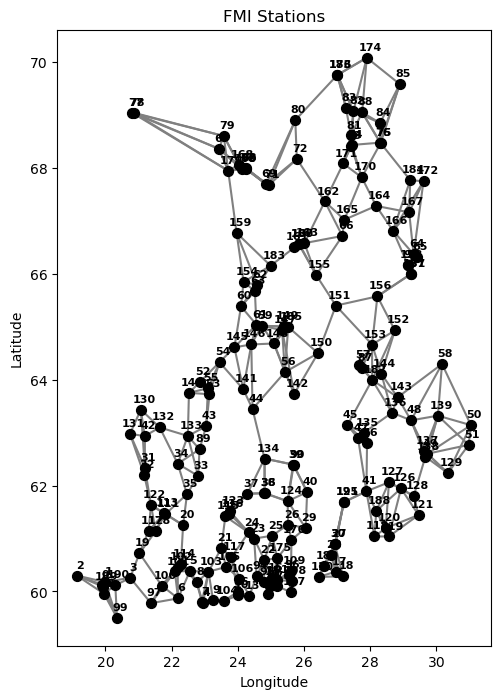

In [5]:
for node in G_FMI.nodes:
    X_train_obj = G_FMI.nodes[node]['X_train'] 
    X_train_array = np.array([row[0] for row in X_train_obj], dtype=float)
    G_FMI.nodes[node]['X_train'] = X_train_array
    
    X_val_obj = G_FMI.nodes[node]['X_val'] 
    X_val_array = np.array([row[0] for row in X_val_obj], dtype=float)
    G_FMI.nodes[node]['X_val'] = X_val_array

plotFMI(G_FMI)

### Task 1: Non-parametric Local Model -  Decision Tree

In [6]:
def fed_decision_tree(
    graph,
    max_iter=10,
    max_depth=5
):
    np.random.seed(RANDOM_STATE)
    G = copy.deepcopy(graph)

    # Create an unlabeled public dataset with uniform random values
    # -33, 12 are the lowest and highest temperature in our dataset respectively
    X_public = np.random.uniform(low=-33, high=12, size=(10, 10))

    for node in G.nodes:

        X_train = G.nodes[node]['X_train']
        y_train = G.nodes[node]['y_train']

        # Create an initial tree solely on local data
        reg = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_STATE)
        reg.fit(X_train, y_train)

        G.nodes[node]['model'] = reg

    for _ in range(max_iter):
        new_models = {}
        
        # For each node i, gather neighbors' predictions on X_public
        for node in G.nodes:
            neighbors = list(G.neighbors(node))
            
            # If no neighbors, we have no pseudo-labels
            if len(neighbors) == 0:
                # Just train on local data alone
                X_aug = G.nodes[node]['X_train']
                y_aug = G.nodes[node]['y_train']
            else:
                # Gather predictions from neighbors on X_public
                # Average the predictions across neighbors
                y_public_pred_list = []
                for nbr in neighbors:
                    neighbor_model = G.nodes[nbr]['model'] 
                    y_public_pred_nbr = neighbor_model.predict(X_public)
                    y_public_pred_list.append(y_public_pred_nbr)

                y_public_i = np.mean(y_public_pred_list, axis=0).reshape(-1,1)

                X_local = G.nodes[node]['X_train']
                y_local = G.nodes[node]['y_train']

                # concat X_local and X_public, store them as augmented feature data
                X_aug = np.concatenate([X_local, X_public], axis=0)
                # concat y_local and y_public, store them as augmented label data
                y_aug = np.concatenate([y_local, y_public_i], axis=0)

            # Train a fresh tree on the augmented data
            reg_new = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_STATE)
            reg_new.fit(X_aug, y_aug)

            # Store in a local dict so we don't overwrite the old model
            new_models[node] = reg_new

        for node in G.nodes:
            G.nodes[node]['model'] = new_models[node]

    return G

In [7]:
G_dt = fed_decision_tree(
    G_FMI, 
    max_iter=10,
    max_depth=5
)

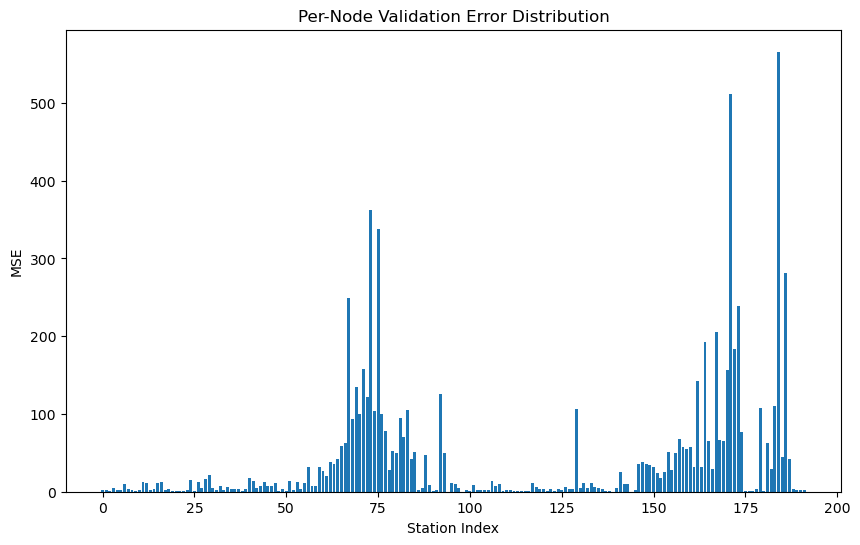

Average MSE: 38.97101978432444


In [8]:
mse_list = []
for node in G_dt.nodes():
    reg = G_dt.nodes[node]['model']
    X_val_local = G_dt.nodes[node]['X_val']
    y_val_local = G_dt.nodes[node]['y_val']
    y_pred = reg.predict(X_val_local)
    mse = mean_squared_error(y_val_local, y_pred)
    mse_list.append(mse)

plt.figure(figsize=(10, 6))
plt.bar(range(len(mse_list)), mse_list)
plt.title('Per-Node Validation Error Distribution')
plt.xlabel('Station Index')
plt.ylabel('MSE')
plt.show()

avg_mse = np.mean(mse_list)
print("Average MSE:", avg_mse)

In [9]:
def fed_decision_tree_ref(
    graph,
    max_iter=10,
    max_depth=5
):
    np.random.seed(RANDOM_STATE)
    G = copy.deepcopy(graph)
    X_public = np.random.uniform(low=-33, high=12, size=(10, 10))

    for node in G.nodes:
        X_train = G.nodes[node]['X_train']
        y_train = G.nodes[node]['y_train']

        reg = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_STATE)
        reg.fit(X_train, y_train)
        G.nodes[node]['model'] = reg

    for _ in range(max_iter):
        new_models = {}
        for node in G.nodes:
            neighbors = list(G.neighbors(node))
            if len(neighbors) == 0:
                X_aug = G.nodes[node]['X_train']
                y_aug = G.nodes[node]['y_train']
            else:
                y_public_pred_list = []
                for nbr in neighbors:
                    neighbor_model = G.nodes[nbr]['model'] 
                    y_public_pred_nbr = neighbor_model.predict(X_public)
                    y_public_pred_list.append(y_public_pred_nbr)

                y_public_i = np.mean(y_public_pred_list, axis=0).reshape(-1,1)

                X_local = G.nodes[node]['X_train']
                y_local = G.nodes[node]['y_train']
                
                X_aug = np.concatenate([X_local, X_public], axis=0)
                y_aug = np.concatenate([y_local, y_public_i], axis=0)

            reg_new = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_STATE)
            reg_new.fit(X_aug, y_aug)

            new_models[node] = reg_new

        for node in G.nodes:
            G.nodes[node]['model'] = new_models[node]
    return G

G_dt_ref = fed_decision_tree_ref(
    G_FMI, 
    max_iter=10,
    max_depth=5
)

mse_list_ref = []
for node in G_dt_ref.nodes():
    reg = G_dt_ref.nodes[node]['model']
    X_val_local = G_dt_ref.nodes[node]['X_val']
    y_val_local = G_dt_ref.nodes[node]['y_val']
    y_pred = reg.predict(X_val_local)
    mse_ref = mean_squared_error(y_val_local, y_pred)
    mse_list_ref.append(mse_ref)

np.testing.assert_allclose(np.array(mse_list_ref), np.array(mse_list), rtol=0.01, atol=0.01)